# Setup

In [1]:
import torch
import pandas as pd

import sys
assert sys.version_info >= (3, 5)


import sklearn
assert sklearn.__version__ >= "0.20"


import numpy as np
import os

import os
import tarfile
import urllib

from rdkit.Chem import PandasTools
from rdkit import DataStructs

%matplotlib inline

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs

# Retrieve Dataset and Isolate One Set of Toxicity Data - SR-ARE

In [2]:
import os 
datapath = os.path.join("")
tox21_raw = pd.read_csv(datapath + "tox21.csv", thousands=',')

array([[<AxesSubplot:title={'center':'NR-AR'}>,
        <AxesSubplot:title={'center':'NR-AR-LBD'}>,
        <AxesSubplot:title={'center':'NR-AhR'}>],
       [<AxesSubplot:title={'center':'NR-Aromatase'}>,
        <AxesSubplot:title={'center':'NR-ER'}>,
        <AxesSubplot:title={'center':'NR-ER-LBD'}>],
       [<AxesSubplot:title={'center':'NR-PPAR-gamma'}>,
        <AxesSubplot:title={'center':'SR-ARE'}>,
        <AxesSubplot:title={'center':'SR-ATAD5'}>],
       [<AxesSubplot:title={'center':'SR-HSE'}>,
        <AxesSubplot:title={'center':'SR-MMP'}>,
        <AxesSubplot:title={'center':'SR-p53'}>]], dtype=object)

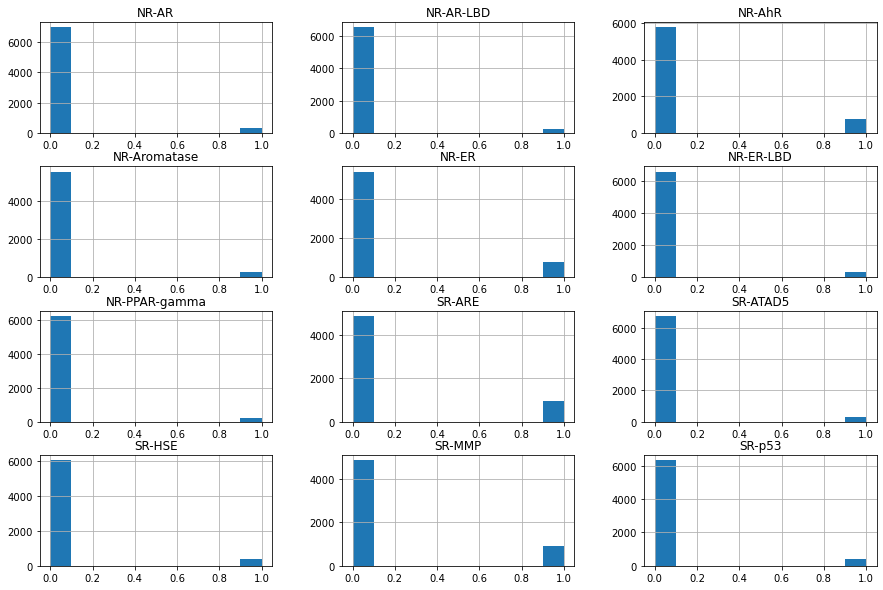

In [3]:
tox21_raw.hist(figsize=(15, 10))

In [4]:
tox21_sr_are = tox21_raw[["SR-ARE", "cano_smiles", "group"]]
print("Number of datapoints before drop NaNs: ", tox21_sr_are.shape[0])
tox21 = tox21_sr_are.dropna()
print("Number of datapoints after drop NaNs: ", tox21.shape[0])

Number of datapoints before drop NaNs:  7811
Number of datapoints after drop NaNs:  5816


# Generate Molecules 

/opt/conda/envs/torch21/lib/python3.7/site-packages/rdkit/Chem/PandasTools.py:425: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,SR-ARE,cano_smiles,group,Molecule
0,1.0,s1c2cc(OCC)ccc2nc1S(=O)(=O)N,train,
1,0.0,O[C@]1(CC[C@H]2[C@H]3[C@@H]([C@@H]4C(CC3)=CCCC...,train,
3,0.0,P(O)(O)(=O)C(P(O)(O)=O)(O)C,train,
5,0.0,ClS(=O)(=O)c1ccccc1,train,
6,1.0,Ic1cc(cc(I)c1Oc1cc(I)c(O)cc1)CC(O)=O,train,

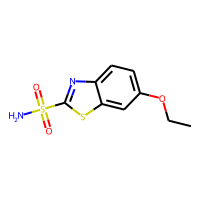
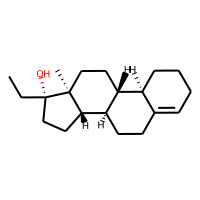
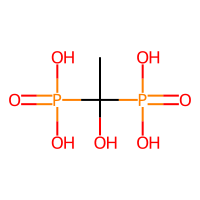
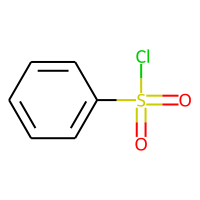
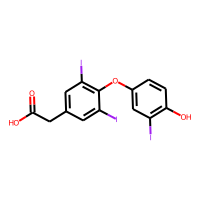

In [5]:
# Create Mol rdkit objects for each smile
PandasTools.AddMoleculeColumnToFrame(frame=tox21, smilesCol='cano_smiles', molCol='Molecule')
tox21.head()

In [6]:
tox21.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5816 entries, 0 to 7810
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SR-ARE       5816 non-null   float64
 1   cano_smiles  5816 non-null   object 
 2   group        5816 non-null   object 
 3   Molecule     5816 non-null   object 
dtypes: float64(1), object(3)
memory usage: 227.2+ KB


# Generate Descriptors 

In [7]:
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
descriptors = list(np.array(Descriptors._descList)[:,0])
print(np.array(Descriptors._descList)[:,0])

['MaxEStateIndex' 'MinEStateIndex' 'MaxAbsEStateIndex' 'MinAbsEStateIndex'
 'qed' 'MolWt' 'HeavyAtomMolWt' 'ExactMolWt' 'NumValenceElectrons'
 'NumRadicalElectrons' 'MaxPartialCharge' 'MinPartialCharge'
 'MaxAbsPartialCharge' 'MinAbsPartialCharge' 'FpDensityMorgan1'
 'FpDensityMorgan2' 'FpDensityMorgan3' 'BCUT2D_MWHI' 'BCUT2D_MWLOW'
 'BCUT2D_CHGHI' 'BCUT2D_CHGLO' 'BCUT2D_LOGPHI' 'BCUT2D_LOGPLOW'
 'BCUT2D_MRHI' 'BCUT2D_MRLOW' 'BalabanJ' 'BertzCT' 'Chi0' 'Chi0n' 'Chi0v'
 'Chi1' 'Chi1n' 'Chi1v' 'Chi2n' 'Chi2v' 'Chi3n' 'Chi3v' 'Chi4n' 'Chi4v'
 'HallKierAlpha' 'Ipc' 'Kappa1' 'Kappa2' 'Kappa3' 'LabuteASA' 'PEOE_VSA1'
 'PEOE_VSA10' 'PEOE_VSA11' 'PEOE_VSA12' 'PEOE_VSA13' 'PEOE_VSA14'
 'PEOE_VSA2' 'PEOE_VSA3' 'PEOE_VSA4' 'PEOE_VSA5' 'PEOE_VSA6' 'PEOE_VSA7'
 'PEOE_VSA8' 'PEOE_VSA9' 'SMR_VSA1' 'SMR_VSA10' 'SMR_VSA2' 'SMR_VSA3'
 'SMR_VSA4' 'SMR_VSA5' 'SMR_VSA6' 'SMR_VSA7' 'SMR_VSA8' 'SMR_VSA9'
 'SlogP_VSA1' 'SlogP_VSA10' 'SlogP_VSA11' 'SlogP_VSA12' 'SlogP_VSA2'
 'SlogP_VSA3' 'SlogP_VSA4' 'SlogP_VS

In [8]:
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors)
# Define a custom function to calculate molecular descriptors
def computeDescriptors(mol, calculator):
    res = list(calculator.CalcDescriptors(mol))
    if not np.all(np.isfinite(res)):
        return None  
# Make it's easier to identify problematic molecules (e.g.: infinty descriptor values) later 
    return res

# Compute the descriptors
tox21['Descriptors'] = tox21['Molecule'].map(lambda x: computeDescriptors(x,calculator))
# Remove rows with non-finite descriptor values (seems to be only 1 by comparing the counts)
tox21 = tox21[tox21['Descriptors'].map(lambda x: x is not None)]

df_descriptors = pd.DataFrame(descriptors, columns=['desc_name'])
df_descriptors

/opt/conda/envs/torch21/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,desc_name
0,MaxEStateIndex
1,MinEStateIndex
2,MaxAbsEStateIndex
3,MinAbsEStateIndex
4,qed
...,...
203,fr_thiazole
204,fr_thiocyan
205,fr_thiophene
206,fr_unbrch_alkane


In [9]:
desc_name = [df_descriptors['desc_name'][i] for i in range(len(df_descriptors))]
desc_val = [list(l) for l in tox21['Descriptors']]
df_desc = pd.DataFrame(desc_val, index = tox21.index, columns=desc_name)

tox21 = pd.concat([tox21, df_desc], axis= 1, ignore_index=False)

df_desc.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.107593,-3.723219,11.107593,0.073011,0.900283,258.324,248.244,258.013284,86,0,...,0,1,0,0,0,1,0,0,0,0
1,11.165775,-0.369724,11.165775,0.207144,0.666269,288.475,256.219,288.245316,118,0,...,0,0,0,0,0,0,0,0,0,0
3,10.251875,-5.197724,10.251875,0.383488,0.365583,206.027,197.963,205.974526,68,0,...,0,0,0,0,0,0,0,0,0,0
5,10.598302,-3.530602,10.598302,0.135802,0.609724,176.624,171.584,175.969878,54,0,...,0,0,0,0,0,0,0,0,0,0
6,10.775986,-0.858003,10.775986,0.010525,0.489304,621.934,612.862,621.763503,110,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
tox21.shape

(5734, 213)

In [11]:
#Finds Null data in any row if any
sample_incomplete_rows = tox21[tox21.isnull().any(axis=1)]
sample_incomplete_rows.head(len(sample_incomplete_rows))

,SR-ARE,cano_smiles,group,Molecule,Descriptors,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea


In [12]:
#Returns number of unique values in the specifed column to make sure that no duplications there
tox21['cano_smiles'].nunique()

5731

In [13]:
tox21['cano_smiles'].count()

5734

In [14]:
tox21 = tox21.drop_duplicates(subset='cano_smiles', keep='first')
tox21['cano_smiles'].count()

5731

In [15]:
tox21.describe()

,SR-ARE,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,5731.000000,5731.000000,5731.000000,5731.000000,5731.000000,5731.000000,5731.000000,5731.000000,5731.000000,5731.000000,...,5731.000000,5731.000000,5731.000000,5731.000000,5731.000000,5731.000000,5731.000000,5731.00000,5731.000000,5731.000000
mean,0.158088,9.625370,-0.724984,9.625370,0.361500,0.557334,245.177064,229.056978,244.833499,90.386320,...,0.032804,0.034200,0.006282,0.005235,0.002792,0.011865,0.001221,0.01012,0.617868,0.029663
std,0.364855,3.070199,1.566256,3.070199,0.489890,0.173928,134.590583,128.168221,134.431114,48.130184,...,0.194080,0.199168,0.083315,0.072168,0.052769,0.109889,0.034931,0.11319,2.147572,0.184456
min,0.000000,1.500000,-9.769375,1.500000,0.000000,0.012914,30.026000,28.010000,30.010565,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,8.366551,-1.061277,8.366551,0.078769,0.443206,153.141000,142.093000,153.042593,58.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,10.518100,-0.369600,10.518100,0.206258,0.555006,214.393000,200.174000,214.088832,80.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.000000,11.766582,0.221099,11.766582,0.474391,0.684759,307.685500,288.181000,307.178358,112.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,17.291804,4.000000,17.291804,8.764932,0.944994,1950.681000,1904.313000,1949.500417,632.000000,...,3.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,3.00000,35.000000,4.000000


,SR-ARE,cano_smiles,group,Molecule,Descriptors,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,s1c2cc(OCC)ccc2nc1S(=O)(=O)N,train,,"[11.107593458679768, -3.723219416624674, 11.10...",11.107593,-3.723219,11.107593,0.073011,0.900283,...,0,1,0,0,0,1,0,0,0,0
1,0.0,O[C@]1(CC[C@H]2[C@H]3[C@@H]([C@@H]4C(CC3)=CCCC...,train,,"[11.165774675610987, -0.36972426933736435, 11....",11.165775,-0.369724,11.165775,0.207144,0.666269,...,0,0,0,0,0,0,0,0,0,0
3,0.0,P(O)(O)(=O)C(P(O)(O)=O)(O)C,train,,"[10.251875, -5.1977237654321, 10.251875, 0.383...",10.251875,-5.197724,10.251875,0.383488,0.365583,...,0,0,0,0,0,0,0,0,0,0
5,0.0,ClS(=O)(=O)c1ccccc1,train,,"[10.598302469135803, -3.5306018518518507, 10.5...",10.598302,-3.530602,10.598302,0.135802,0.609724,...,0,0,0,0,0,0,0,0,0,0
6,1.0,Ic1cc(cc(I)c1Oc1cc(I)c(O)cc1)CC(O)=O,train,,"[10.775986052193767, -0.8580030862462318, 10.7...",10.775986,-0.858003,10.775986,0.010525,0.489304,...,0,0,0,0,0,0,0,0,0,0

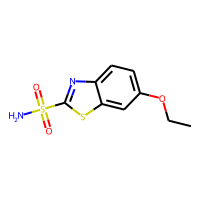
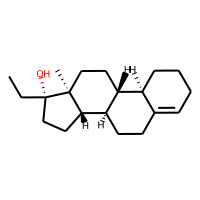
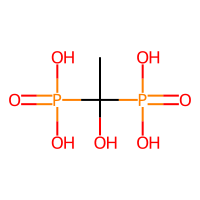
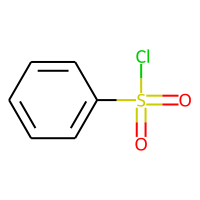
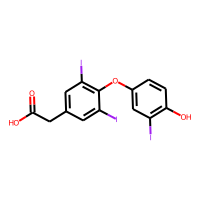

In [16]:
tox21.head()

# Split Data

In [17]:
train_data = tox21[tox21["group"]=="train"]
valid_data = tox21[tox21["group"]=="valid"]
test_data = tox21[tox21["group"]=="test"]

,SR-ARE,cano_smiles,group,Molecule,Descriptors,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,s1c2cc(OCC)ccc2nc1S(=O)(=O)N,train,,"[11.107593458679768, -3.723219416624674, 11.10...",11.107593,-3.723219,11.107593,0.073011,0.900283,...,0,1,0,0,0,1,0,0,0,0
1,0.0,O[C@]1(CC[C@H]2[C@H]3[C@@H]([C@@H]4C(CC3)=CCCC...,train,,"[11.165774675610987, -0.36972426933736435, 11....",11.165775,-0.369724,11.165775,0.207144,0.666269,...,0,0,0,0,0,0,0,0,0,0
3,0.0,P(O)(O)(=O)C(P(O)(O)=O)(O)C,train,,"[10.251875, -5.1977237654321, 10.251875, 0.383...",10.251875,-5.197724,10.251875,0.383488,0.365583,...,0,0,0,0,0,0,0,0,0,0
5,0.0,ClS(=O)(=O)c1ccccc1,train,,"[10.598302469135803, -3.5306018518518507, 10.5...",10.598302,-3.530602,10.598302,0.135802,0.609724,...,0,0,0,0,0,0,0,0,0,0
6,1.0,Ic1cc(cc(I)c1Oc1cc(I)c(O)cc1)CC(O)=O,train,,"[10.775986052193767, -0.8580030862462318, 10.7...",10.775986,-0.858003,10.775986,0.010525,0.489304,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6239,0.0,O=C1N(CCCCC(=O)C)C(=O)N(c2ncn(c12)CCC)C,train,,"[12.608190035273369, -0.359191232048375, 12.60...",12.608190,-0.359191,12.608190,0.121966,0.716684,...,0,0,0,0,0,0,0,0,1,0
6240,0.0,O=C1N(C=C(C=C1)C)c1ccccc1,train,,"[11.534818594104308, 0.0016666666666669272, 11...",11.534819,0.001667,11.534819,0.001667,0.666820,...,0,0,0,0,0,0,0,0,0,0
6245,0.0,O(CC)c1nc2c(n1Cc1ccc(cc1)-c1ccccc1-c1[nH]nnn1)...,train,,"[11.81910704085061, -1.0012415034137059, 11.81...",11.819107,-1.001242,11.819107,0.191822,0.392116,...,0,0,0,0,1,0,0,0,0,0
6247,0.0,Oc1cc2CC[C@H]3[C@@H]4CC[C@@H](O)[C@]4(CC[C@@H]...,train,,"[10.372486615016378, -0.08827338960275544, 10....",10.372487,-0.088273,10.372487,0.088273,0.757170,...,0,0,0,0,0,0,0,0,0,0

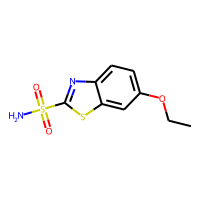
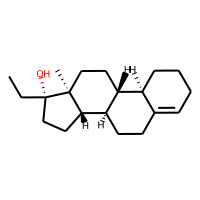
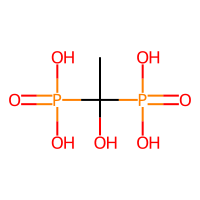
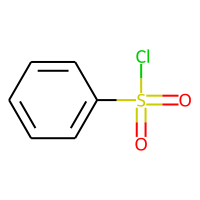
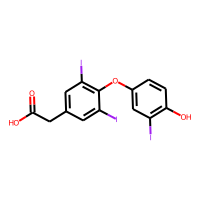
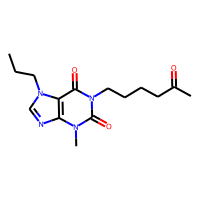
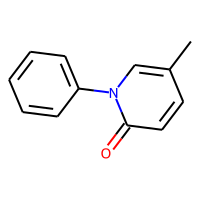
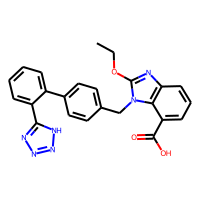
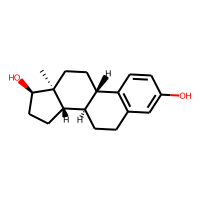
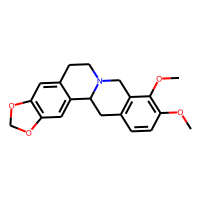

In [18]:
train_data

# Random Forest Classification with Default Parameters Using Descriptors 

## Preprocess the Data

In [20]:
X_train = train_data.drop(["cano_smiles", "SR-ARE", "group", "Molecule", "Descriptors"], axis = 1).values
X_valid = valid_data.drop(["cano_smiles", "SR-ARE", "group", "Molecule", "Descriptors"], axis = 1).values
X_test = test_data.drop(["cano_smiles", "SR-ARE", "group", "Molecule", "Descriptors"], axis = 1).values

y_train = train_data["SR-ARE"].values
y_valid = valid_data["SR-ARE"].values
y_test = test_data["SR-ARE"].values

In [21]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_valid = np.array(X_valid)

In [22]:
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))
print(type(X_valid))
print(type(y_valid))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [23]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Random Forest Classification

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

forest_reg = RandomForestClassifier()
forest_reg.fit(X_train, y_train)

RandomForestClassifier()

In [41]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## ROC_AUC With Predict Proba

### Training Dataset 

In [42]:
y_train_pred = forest_reg.predict_proba(X_train)[:, 1]

In [43]:
from sklearn.metrics import roc_curve, auc

fpr_train, tpr_train, thresholds_forest = roc_curve(y_train, y_train_pred)

In [44]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_train_pred)

0.9999992919363947

In [45]:
AUC = auc(fpr_train, tpr_train)
AUC

0.9999992919363947

### Validation Dataset 

In [46]:
y_valid_pred = forest_reg.predict_proba(X_valid)[:, 1]

In [47]:
from sklearn.metrics import roc_curve, auc

fpr_valid, tpr_valid, thresholds_forest = roc_curve(y_valid, y_valid_pred)

In [48]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, y_valid_pred)

0.587827620967742

In [49]:
AUC = auc(fpr_valid, tpr_valid)
AUC

0.587827620967742

### Test Dataset 

In [50]:
y_test_pred = forest_reg.predict_proba(X_test)[:, 1]

In [51]:
from sklearn.metrics import roc_curve, auc

fpr_test, tpr_test, thresholds_forest = roc_curve(y_test, y_test_pred)

In [52]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_test_pred)

0.8619138063582508

In [53]:
AUC = auc(fpr_test, tpr_test)
AUC

0.8619138063582508

# Random Forest Classification with Grid Search Using Descriptors 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

param_grid = {
        'n_estimators': [10, 50, 100, 200, 300, 400, 500, 1000],  
        'max_depth': range(3, 12),
        'min_samples_leaf': [1, 3, 5, 10, 20, 50],
        'min_impurity_decrease': [0, 0.01] ,
        'max_features':  ['sqrt', 'log2', 0.7, 0.8, 0.9]
        }

from sklearn.model_selection import ParameterGrid
grid = ParameterGrid(param_grid)
len(grid)

In [ ]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

best_model = None
best_rmse=np.inf
best_param = {}
for this_param in tqdm(grid):
    this_model = RandomForestClassifier(**this_param, random_state=42)
    this_model.fit(X_train, y_train)
    forest_mse = mean_squared_error(y_valid, this_model.predict(X_valid))
    forest_rmse = np.sqrt(forest_mse)
    if best_rmse > forest_rmse:
        best_model = this_model
        best_rmse = forest_rmse
        best_param = this_param

In [ ]:
print(best_param)

## ROC_AUC With Predict Proba

### Training Dataset 

In [ ]:
y_train_pred = best_model.predict_proba(X_train)[:, 1]

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr_train, tpr_train, thresholds_forest = roc_curve(y_train, y_train_pred)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_train_pred)

In [ ]:
AUC = auc(fpr_train, tpr_train)
AUC

### Validation Dataset 

In [ ]:
y_valid_pred = best_model.predict_proba(X_valid)[:, 1]

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr_valid, tpr_valid, thresholds_forest = roc_curve(y_valid, y_valid_pred)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, y_valid_pred)

In [ ]:
AUC = auc(fpr_valid, tpr_valid)
AUC

### Test Dataset 

In [ ]:
y_test_pred = best_model.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr_test, tpr_test, thresholds_forest = roc_curve(y_test, y_test_pred)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_test_pred)

In [ ]:
AUC = auc(fpr_test, tpr_test)
AUC

In [ ]:
|<div align="center">Model name</div>||<div align="center">Training RMSE</div>||<div align="center">Validation RMSE</div>||<div align="center">Test RMSE</div>|
|---||---||---||---|
|<div align="center">Random Forest Model with Default Parameters Using Descriptors</div>||<div align="center">0.242</div>||<div align="center">0.638</div>||<div align="center">0.610</div>|
|<div align="center">Random Forest Model with GridSearch Using Descriptors)</div>||<div align="center">0.298</div>||<div align="center">0.648</div>||<div align="center">0.577</div>|
<br>